In [0]:
#!pip install lime

In [0]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn.utils import shuffle
from __future__ import print_function
from io import StringIO
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df_train = pd.read_csv('/content/drive/My Drive/WSU/Semester 2/IE 7860/Final Project/drugsComTrain_raw.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('/content/drive/My Drive/WSU/Semester 2/IE 7860/Final Project/drugsComTest_raw.csv', dtype={'id': np.int16})

In [0]:
df_train = df_train.loc[(df_train['rating'] <= 3) | (df_train['rating'] == 10)]
df_train['target']=df_train['rating'].apply(lambda x: 1 if x>=8 else 0)

df_test = df_test.loc[(df_test['rating'] <= 3) | (df_test['rating'] == 10)]
df_test['target']=df_test['rating'].apply(lambda x: 1 if x>=8 else 0)

df = pd.concat([df_train, df_test], axis=0,ignore_index=True)

In [0]:
df.drop(['uniqueID','date', 'condition', 'drugName', 'usefulCount', 'rating'],axis=1,inplace=True)

In [0]:
df['tag']=df['target'].apply(lambda x: "pos" if x>=1 else "neg")

In [0]:
df['post'] = df['review']
df['class_label'] = df['target']
df.drop(['review','target'],axis=1,inplace=True)

In [0]:
df['tags'] = df['tag']
df.drop(['tag'],axis=1,inplace=True)

In [0]:
df

,post,class_label,tags
0,"""2nd day on 5mg started to work with rock hard...",0,neg
1,"""He pulled out, but he cummed a bit in me. I t...",0,neg
2,"""Abilify changed my life. There is hope. I was...",1,pos
3,""" I Ve had nothing but problems with the Kepp...",0,neg
4,"""I have taken anti-depressants for years, with...",1,pos
...,...,...,...
114901,"""Treatment for ADHD save my life. Don&#039;t b...",1,pos
114902,"""This is my 3rd time taking this medicine. Fir...",1,pos
114903,"""This medicine kept me from sleeping the whole...",0,neg
114904,"""I have taken Tamoxifen for 5 years. Side effe...",1,pos


In [0]:
#df = pd.read_csv('stack-overflow-data.csv')

df['class_label'] = df['tags'].factorize()[0]
class_label_df = df[['tags', 'class_label']].drop_duplicates().sort_values('class_label')
label_to_id = dict(class_label_df.values)
id_to_label = dict(class_label_df[['class_label', 'tags']].values)

In [0]:
label_to_id

{'neg': 0, 'pos': 1}

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding. BeautifulSoup's text attribute will return a string stripped of any HTML tags and metadata.
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
    
df['post'] = df['post'].apply(clean_text)

In [0]:
df.head()

,post,class_label,tags
0,2nd day 5mg started work rock hard erections h...,0,neg
1,pulled cummed bit took plan b 26 hours later t...,0,neg
2,abilify changed life hope zoloft clonidine fir...,1,pos
3,nothing problems keppera constant shaking arms...,0,neg
4,taken antidepressants years improvement mostly...,1,pos


In [0]:
list_corpus = df["post"].tolist()
list_labels = df["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)
vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 3), stop_words = 'english', binary=True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

In [0]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
pred = logreg.predict(test_vectors)
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.951, precision = 0.951, recall = 0.951, f1 = 0.951


In [0]:
c = make_pipeline(vectorizer, logreg)
class_names=list(df.tags.unique())
explainer = LimeTextExplainer(class_names=class_names)

In [0]:
class_names

['neg', 'pos']

In [0]:
idx = 1877
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=100, labels=[1])
print('Document id: %d' % idx)
print('Predicted class =', class_names[logreg.predict(test_vectors[idx]).reshape(1,-1)[0,0]])
print('True class: %s' % class_names[y_test[idx]])

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Document id: 1877
Predicted class = neg
True class: neg


In [0]:
print ('Explanation for class %s' % class_names[1])
print ('\n'.join(map(str, exp.as_list(label=1))))

Explanation for class pos
('dont', -0.4051956086626073)
('recommend', -0.27578704312605745)
('thanks', 0.2624516056364077)
('hate', -0.25858579810602345)
('helps', 0.23828279666061566)
('sucks', -0.23762808320258072)
('lost', 0.190650915724657)
('seizures', 0.17401893514887304)
('pounds', 0.15925497080278897)
('times', 0.14131079121168189)
('med', -0.1295442245439019)
('severe', -0.11711393844799471)
('hard', 0.11625591397296023)
('week', 0.11494026320066263)
('causes', -0.11174643712398857)
('brutal', -0.10497917449821581)
('helped', 0.08554077107900146)
('30', 0.081190213997593)
('appetite', -0.07608730768445952)
('foggy', -0.07081053564168108)
('months', -0.06777850591088763)
('5', 0.0671029336381334)
('headaches', -0.065408938081673)
('passed', -0.04826236781222892)
('eat', 0.04557789486033937)
('eating', 0.04157499251417532)
('effects', -0.039202475725265196)
('qudexy', 0.03695958145512158)
('cruel', -0.036615564670814234)
('taking', -0.03037882990262201)
('concentrate', 0.0291613

In [0]:
print ('Explanation for class %s' % class_names[1])
print ('\n'.join(map(str, exp.as_list(label=1))))

Explanation for class pos
('dont', -0.4051956086626073)
('recommend', -0.27578704312605745)
('thanks', 0.2624516056364077)
('hate', -0.25858579810602345)
('helps', 0.23828279666061566)
('sucks', -0.23762808320258072)
('lost', 0.190650915724657)
('seizures', 0.17401893514887304)
('pounds', 0.15925497080278897)
('times', 0.14131079121168189)
('med', -0.1295442245439019)
('severe', -0.11711393844799471)
('hard', 0.11625591397296023)
('week', 0.11494026320066263)
('causes', -0.11174643712398857)
('brutal', -0.10497917449821581)
('helped', 0.08554077107900146)
('30', 0.081190213997593)
('appetite', -0.07608730768445952)
('foggy', -0.07081053564168108)
('months', -0.06777850591088763)
('5', 0.0671029336381334)
('headaches', -0.065408938081673)
('passed', -0.04826236781222892)
('eat', 0.04557789486033937)
('eating', 0.04157499251417532)
('effects', -0.039202475725265196)
('qudexy', 0.03695958145512158)
('cruel', -0.036615564670814234)
('taking', -0.03037882990262201)
('concentrate', 0.0291613

In [0]:
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=100, top_labels=1)
print(exp.available_labels())

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


[0]


In [0]:
#exp.show_in_notebook(text=False)

In [0]:
#exp.show_in_notebook(text=y_test[idx], labels=(0,))

In [0]:
#exp.show_in_notebook(text=y_test[idx], labels=(0,))

In [0]:
#!pip install shap

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras.preprocessing import text
import keras.backend.tensorflow_backend as K
K.set_session
import shap

Using TensorFlow backend.


In [0]:
tags_split = [tags.split(',') for tags in df['tags'].values]
print(tags_split[:10])

[['neg'], ['neg'], ['pos'], ['neg'], ['pos'], ['neg'], ['pos'], ['pos'], ['pos'], ['pos']]


In [0]:
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)
num_tags = len(tags_encoded[0])
print(df['post'].values[0])
print(tag_encoder.classes_)
print(tags_encoded[0])

2nd day 5mg started work rock hard erections however experianced headache lower bowel preassure 3rd day erections would wake hurt leg ankles aches severe lower bowel preassure like need go #2 cant enjoyed initial rockhard erections side effects 230 months supply im 50 work 3xs week worth side effects
['neg' 'pos']
[1 0]


In [0]:
train_size = int(len(df) * .8)
print('train size: %d' % train_size)
print('test size: %d' % (len(df) - train_size))

train size: 91924
test size: 22982


In [0]:
df['class_label'][train_size:]

91924     0
91925     0
91926     0
91927     1
91928     0
         ..
114901    1
114902    1
114903    0
114904    1
114905    0
Name: class_label, Length: 22982, dtype: int64

In [0]:
y_train = df['class_label'][: train_size]
y_test = df['class_label'][train_size:]

In [0]:
class TextPreprocessor(object):
    def __init__(self, vocab_size):
        self._vocab_size = vocab_size
        self._tokenizer = None
    def create_tokenizer(self, text_list):
        tokenizer = text.Tokenizer(num_words = self._vocab_size)
        tokenizer.fit_on_texts(text_list)
        self._tokenizer = tokenizer
    def transform_text(self, text_list):
        text_matrix = self._tokenizer.texts_to_matrix(text_list)
        return text_matrix

In [0]:
VOCAB_SIZE = 2000
train_post = df['post'].values[: train_size]
test_post = df['post'].values[train_size: ]
processor = TextPreprocessor(VOCAB_SIZE)
processor.create_tokenizer(train_post)
X_train = processor.transform_text(train_post)
X_test = processor.transform_text(test_post)

In [0]:
print(len(X_train[0]))
print(X_train[0])

2000
[0. 1. 1. ... 0. 0. 0.]


In [0]:
def create_model(vocab_size, num_tags):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(50, input_shape = (VOCAB_SIZE,), activation='relu'))
    model.add(tf.keras.layers.Dense(25, activation='relu'))
    model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model
model = create_model(VOCAB_SIZE, num_tags)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100050    
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 52        
Total params: 101,377
Trainable params: 101,377
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(X_train, y_train, epochs = 2, batch_size=128, validation_split=0.1)
print('Eval loss/accuracy:{}'.format(model.evaluate(X_test, y_test, batch_size = 128)))

Epoch 1/2


ValueError: ignored

In [0]:
attrib_data = X_train[:2000]
explainer = shap.DeepExplainer(model, attrib_data)
num_explanations = 20
shap_vals = explainer.shap_values(X_test[:num_explanations])

keras is no longer supported, please use tf.keras instead.


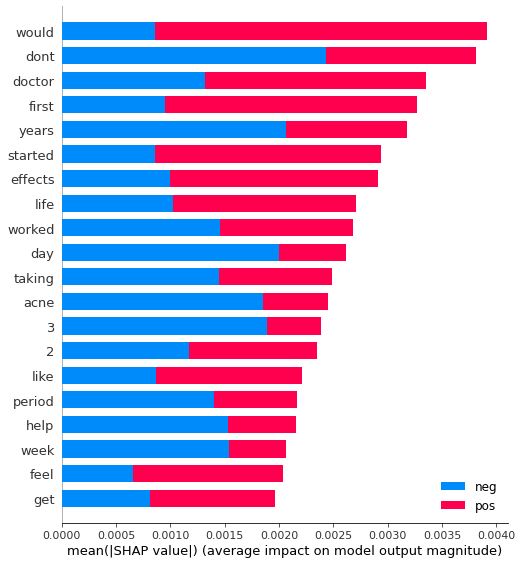

In [0]:
words = processor._tokenizer.word_index
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)

word_lookup = [''] + word_lookup
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=tag_encoder.classes_)